## In-class hands-on activity: Deep Feedforward Network

### Breast Cancer Diagnostic Dataset
Original dataset from <https://www.kaggle.com/code/rcfreitas/python-ml-breast-cancer-diagnostic-data-set>

走過下面的的Cell, 依序執行。下面有些Cell中標明"TODO"。請依照說明完成這些函數或程式片段，讓整個檔案能正確的執行。

課程名稱: 統計學習與深度學習。

Note: You do not need a GPU to run the script. (But it will take a bit longer to run without a GPU.)

# Outline

1. Pytorch Basics
2. Multiple Layer Perceptron (MLP) for Binary Classification
3. Online Resource

In [138]:
import os
import numpy as np
import random
from sklearn.utils import check_random_state

RND_SEED = 1243
os.environ["PYTHONHASHSEED"] = str(RND_SEED)
random.seed(RND_SEED)
np.random.seed(RND_SEED)
np.random.set_state(np.random.RandomState(RND_SEED).get_state())
sklearn_random_state = check_random_state(RND_SEED)

# Pytorch Setup

* It is common to have multiple python environments on your PC.
* To verify that you are using the correct Python interpreter, do the following:

In [139]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


Before install packages via `pip`, confirm which python interpreter `pip` is using:

If you encounter issues when installing package using pip, check the output of these commands
* `!where.exe pip` (for windows); `!which pip` (for Linux and Mac) --> confirm which pip you are using
* `!pip -v`  --> confirm the version of pip

### Setting up torch
To install pytorch, run `!pip3 install torch`. 

If you encounter problems, check the official instruction here: <https://pytorch.org/get-started/locally/>. 

You may want to use Google Colab if you have trouble setting up your own PC.

In [140]:
# install torch (if you have not done so)
# !pip3 install torch

# Pytorch: Three Levels of Abstraction

* Tensor: Essentially ndarray in numpy, but can run on CPU and GPU.
* Variables that hold tensors: Node in a computational graph; stores data and gradient
* Module: A neural network layer; may store state or learnable weights

# PyTorch Basics
## What is PyTorch?
It is a **replacement for NumPy** to use the power of GPUs, and a **deep learning research platform** that provides maximum flexibility and speed ([source](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)).


You can create a [PyTorch tensor](https://pytorch.org/docs/stable/tensors.html) in a similary way that you create a NumPy ndarray:

In [141]:
import numpy as np
import torch
print("torch version:", torch.__version__) 

print('\nCreate a zero ndarray in NumPy:')
zero_np = np.zeros([2, 3])
print(zero_np)
print('\nCreate a zero tensor in PyTorch:')
zero_pt = torch.zeros([2,3])
print(zero_pt)

torch version: 2.5.1

Create a zero ndarray in NumPy:
[[0. 0. 0.]
 [0. 0. 0.]]

Create a zero tensor in PyTorch:
tensor([[0., 0., 0.],
        [0., 0., 0.]])


You can index into the tensor the same way you index a ndarray:

In [142]:
print(f"numpy: zero_np[0,1]: {str(zero_np[0, 1])}; type: {type(zero_np[0, 1])}")
print(f"torch: zero_pt[0,1]: {str(zero_pt[0,1])}; type: {type(zero_pt[0,1])}; shape: {zero_pt[0,1].shape}")

numpy: zero_np[0,1]: 0.0; type: <class 'numpy.float64'>
torch: zero_pt[0,1]: tensor(0.); type: <class 'torch.Tensor'>; shape: torch.Size([])


### Use "item()" to get a Python number from a single-valued tensor.

In [143]:
print(f"    zero_pt[0,1].item(): {zero_pt[0,1].item()}; with datatype = {type(zero_pt[0,1].item())}")

    zero_pt[0,1].item(): 0.0; with datatype = <class 'float'>


### A ndarray can be turned into a tensor, and vice versa:

In [144]:
print('Turn a ndarray into a tensor with "torch.tensor()":')
zero_pt_from_np = torch.tensor(zero_np)
print(zero_pt_from_np)
print('or "torch.from_numpy():"')
zero_pt_from_np = torch.from_numpy(zero_np)
print(zero_pt_from_np)

print('\nTurn a tensor into ndarray with ".numpy()":')
zero_np_from_pt = zero_pt.numpy()
print(zero_np_from_pt)
print(type(zero_np_from_pt))

Turn a ndarray into a tensor with "torch.tensor()":
tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
or "torch.from_numpy():"
tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

Turn a tensor into ndarray with ".numpy()":
[[0. 0. 0.]
 [0. 0. 0.]]
<class 'numpy.ndarray'>


### The design of PyTorch allows it to better utilize GPUs. Upon creation, a PyTorch tensor resides on the CPU. You can move a tensor across devices using `.to()`:

In [145]:
t = torch.randn(2)
print("Initial device:\t'{}'".format(t.device))

Initial device:	'cpu'


If you have GPU, then you can do this:
```python
t = t.to('cuda:0')
print("Move to gpu:\t'{}'".format(t.device))
```

and, you can move it back...

```python
t = t.to('cpu')
print("Back to cpu:\t'{}'".format(t.device))
```

Sometimes, we need to convert the variable back to numpy:

In [146]:
t.numpy()

array([-1.1532313,  0.6877977], dtype=float32)

# MLP Example using Breast Cancer Dataset

We demonstrate the process of constructing Multiple Layer Perception (MLP) for classification here. 

The dataset is from UCI Machine Learning Repository <https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29>

We use the csv format from <https://www.kaggle.com/uciml/breast-cancer-wisconsin-data?select=data.csv>

# Data Columns

```
1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)
Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)
```

# Data Preparations

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('breast_cancer.csv');
print("\n \t The data frame has {0[0]} rows and {0[1]} columns. \n".format(data.shape))
data.info()


 	 The data frame has 569 rows and 33 columns. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 n

In [148]:
data.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


# Drop Unwanted Columns
The first column (id) and the last column (Unnamed) are are needed. 

In [149]:
data.drop(data.columns[[-1, 0]], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

# Number of Malignant and Benign Cases

In [150]:
diagnosis_all = list(data.shape)[0]
diagnosis_categories = list(data['diagnosis'].value_counts())

print("The data has {} diagnosis, {} benign and {} malignant."
      .format(diagnosis_all, diagnosis_categories[0], diagnosis_categories[1]))

The data has 569 diagnosis, 357 benign and 212 malignant.


# Data Visualization

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

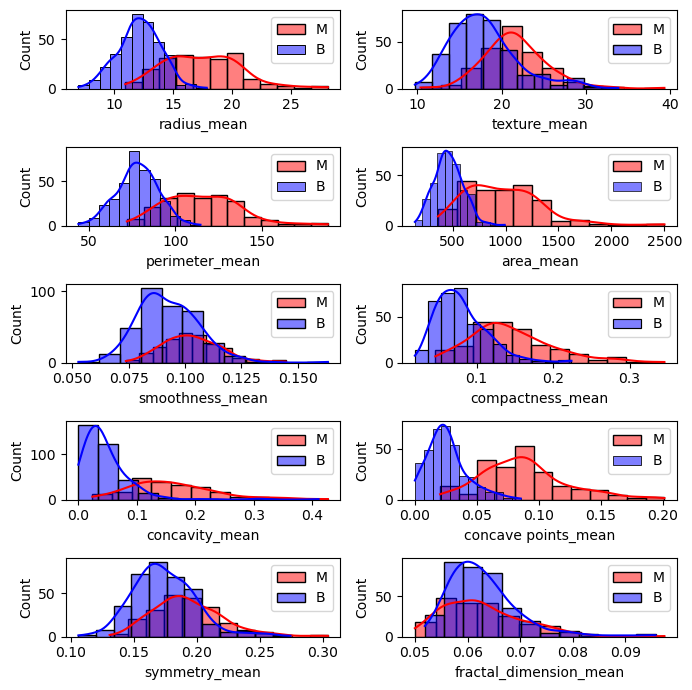

In [151]:
features_name = list(data.columns[1:11]) 
bins = 12; plt.figure(figsize=(7, 7))
for i, feat in enumerate(features_name):
    rows = int(len(features_name)/2)    
    plt.subplot(rows, 2, i+1)    
    sns.histplot(data[data['diagnosis']=='M'][feat], bins=bins, color='red', label='M', kde=True)
    sns.histplot(data[data['diagnosis']=='B'][feat], bins=bins, color='blue',label='B', kde=True)
    
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Transform Label Values and Split Training and Test Sets
* M --> 1
* B --> 0

In [152]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
diag_map = {'M':1, 'B':0}
data['diagnosis'] = data['diagnosis'].map(diag_map)
X = data.loc[:,features_name]
y = data.loc[:, 'diagnosis']
# make sure we are using float32 datatype
X = X.astype('float32')
y = y.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RND_SEED)

# Baseline: Random Foreast Classifier

In [153]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 500)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
accuracy_rf  = accuracy_score(prediction, y_test)
print("Random Forest Accuracy: {0:.2%}".format(accuracy_rf))

Random Forest Accuracy: 92.11%


# Standardize Feature Values

In [154]:
from sklearn import preprocessing
xscaler = preprocessing.StandardScaler().fit(X_train)
#standardize feature values
X_trainstd = xscaler.transform(X_train)
X_teststd = xscaler.transform(X_test)

In [155]:
#Just to verify feature standardization
print("Column means:")
np.mean(X_trainstd, axis = 0)
print("Column Std.dev:")
np.std(X_trainstd, axis = 0)

Column means:
Column Std.dev:


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

# Pytorch Data Loader

* Pytorch provides built-in tools to handle data.
* You should use Pytorch Dataset and DataLoader whenever possible.
* cf. <https://pytorch.org/docs/stable/data.html>

Here we practice on creating your own dataloader. 

# Define Our Dataset Objects

Pytorch uses torch.utils.data.DataLoader() to feed data into a model trainer. A Dataloader() takes in a torch.utils.data.Dataset() object. You are responsible to create the Dataset object so that your data can be loaded using the toolchain. 

Two types of dataset objects in Pytorch: map-style datasets and iterable-style datasets.

We are going to use map-style dataset, which is simpler but cannot handle large dataset because we need to load the whole dataset into memory at once. However, this is a good starting point for small projects.

#### Map-style datasets
A map-style dataset is one that implements the __getitem__() and __len__() protocols, and represents a map from (possibly non-integral) indices/keys to data samples.

For example, such a dataset, when accessed with dataset\[idx\], could read the idx-th image and its corresponding label from a folder on the disk.

In [156]:

# TODO

import torch
from torch.utils import data

class Dataset(data.Dataset):  
  """Characterizes a dataset for PyTorch using NumPy arrays."""  
  
  def __init__(self, Xnp, Ynp):
        """
        Initialize the dataset.

        Args:
            X_np (np.ndarray): Input features.
            Y_np (np.ndarray): Target labels.
        """
        self.Xnp = Xnp
        self.Ynp = Ynp
        
  def __len__(self):
        """Return the total number of samples."""
        return len(self.Xnp)
        
  def __getitem__(self, index):        
        """Return one data point."""
        if isinstance(index, (list, tuple)):
            X = torch.tensor(self.Xnp[index], dtype=torch.float32)
            y = torch.tensor(self.Ynp[index], dtype=torch.float32)
        else:
            X = torch.tensor(self.Xnp[index], dtype=torch.float32)
            y = torch.tensor(self.Ynp[index], dtype=torch.float32)
        return X, y
    
# y_train is a pandas.core.series.Series
trainset = Dataset(X_trainstd, y_train.values)
testset = Dataset(X_teststd, y_test.values)

Let's verify the dataset object can function as expected.

In [157]:
print("Get length:", len(trainset))
print("Get training data at position 3: ", trainset[3])
print("Get training data at position 3, 5, and 6: ", trainset[[3, 5, 6]])

Get length: 455
Get training data at position 3:  (tensor([ 1.4064,  1.6781,  1.3887,  1.3489,  0.4071,  0.7764,  1.2871,  1.2249,
         0.2974, -0.0671]), tensor(1.))
Get training data at position 3, 5, and 6:  (tensor([[ 1.4064,  1.6781,  1.3887,  1.3489,  0.4071,  0.7764,  1.2871,  1.2249,
          0.2974, -0.0671],
        [-0.5889, -0.3653, -0.5859, -0.6068,  0.4705, -0.1296, -0.5252, -0.4148,
          0.4253, -0.1497],
        [-0.3346,  0.3388, -0.3627, -0.3999,  1.2181, -0.5414, -0.7321, -0.5910,
          2.6277, -0.2532]]), tensor([1., 0., 0.]))


### Sanity Check
<pre>
Get length: 455
Get training data at position 3:  (array([ 1.4063512 ,  1.6780852 ,  1.3886514 ,  1.3489482 ,  0.4070717 ,
        0.7763761 ,  1.2870688 ,  1.2248646 ,  0.29742527, -0.06713751],
      dtype=float32), np.float32(1.0))
Get training data at position 3, 5, and 6:  (array([[ 1.4063512 ,  1.6780852 ,  1.3886514 ,  1.3489482 ,  0.4070717 ,
         0.7763761 ,  1.2870688 ,  1.2248646 ,  0.29742527, -0.06713751],
       [-0.5889176 , -0.36530614, -0.5858873 , -0.60680836,  0.4705452 ,
        -0.12960437, -0.52518535, -0.41478568,  0.42525905, -0.14969833],
       [-0.33456331,  0.33883572, -0.3627106 , -0.3998679 ,  1.2181215 ,
        -0.5413965 , -0.73207396, -0.5909614 ,  2.6276526 , -0.25324902]],
      dtype=float32), array([1., 0., 0.], dtype=float32))
</pre>

# Create Dataloader

In [158]:
trainloader = data.DataLoader(trainset, batch_size=228, shuffle=True, num_workers=0)
testloader = data.DataLoader(testset, batch_size=50, shuffle=True, num_workers=0)

In [159]:
X_batch, y_batch = next(iter(trainloader))
print("X_batch size:", X_batch.size())
print("y_batch size:", y_batch.size())

X_batch size: torch.Size([228, 10])
y_batch size: torch.Size([228])


# Creating our MLP Model
We are going to attempt our first MLP model using torch.nn.Sequential(). 

The Sequential() function allows you to create your own model by focusing on the high-level structure. For example, the following code snippet creates 
a MLP model with an linear layer with 128 features for the input and 64 features for the output. The data then flow through a ReLU activation function, followed by another linear layer with 64 features for the input and 10 features for the output. Note that the output of the first linear layer matches the input dimension of the second linear layer. 

```python
net = torch.nn.Sequential(
    nn.Linear(128, 64),   # First layer: fully connected
    nn.ReLU(),            # Activation layer
    nn.Linear(64, 10)     # Output layer
)
```


Modify the code below and create a MLP with the following structure:
* Linear layer
* ReLU
* Linear Layer
* ReLU
* Linear Layer
* Sigmoid

The initial input is of D_in dimension, and the intermediate layers has a dimension of H features. The final linear layer output D_out features. 


In [160]:
# get number of input features
D_in = trainset.Xnp.shape[1]
H = 22
# Binary classification problem
D_out = 1
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = "cuda"   
else:
    device = "cpu"
    
print("Running on device: ", device)

# TODO;
# Hint: net = torch.nn.Sequential(...)
net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),    # First linear layer
    torch.nn.ReLU(),              # ReLU activation
    torch.nn.Linear(H, H),        # Second linear layer
    torch.nn.ReLU(),              # ReLU activation
    torch.nn.Linear(H, D_out),    # Output linear layer
    torch.nn.Sigmoid()            # Sigmoid activation for binary classification
)

# -----------Do not change the code below this line ----
# convert everything to float precision. 
net = net.float()
# move the model to device (i.e., cpu or gpu)
net = net.to(device)

Running on device:  cpu


# Define Optimizer and Loss Function

Recall that Binary Cross Entropy is:
$$
\frac{1}{m} \sum_{i = 1}^{m} [y_i log{\hat{y}_i}  + (1 - y_i) log{(1 - \hat{y}_i)}] 
$$

In [161]:
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.5, weight_decay = 0)
# Binary Cross Entropy Loss
loss_fn = torch.nn.BCELoss()

Below is the training routine. For a minibatch, you need to do the following
* put the net in training mode.
* transform data to appropriate device (cpu/gpu)
* reset optimizer gradient
* pass training data through the net
* compute loss function
* do back propagation
* adjust parameters based on the gradients.

Note that we do not do early stopping in this exercise just to simplify the problem. Run through nepoch of training and take the last model for subsequent model evaluation. 

In [162]:
nepoch = 1500
step_count = 0
log_interval = 100

for epoch_id in range(0, nepoch):      
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # TODO
        # Fill in the code here...
        net.train()  # Set the network to training mode
        inputs = inputs.to(device)  # Move inputs to device
        targets = targets.to(device)  # Move targets to device
        
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = net(inputs)  # Forward pass
        loss = loss_fn(outputs.squeeze(), targets)  # Compute loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        
        step_count += 1
        
        # ----- Do not change the code below this line ---
        if step_count % log_interval == 0:            
            print("Epoch %d Loss = %.3f (minibatch size = %d)" % (step_count, loss.item(), len(targets)))        

Epoch 100 Loss = 0.625 (minibatch size = 227)
Epoch 200 Loss = 0.500 (minibatch size = 227)
Epoch 300 Loss = 0.412 (minibatch size = 227)
Epoch 400 Loss = 0.319 (minibatch size = 227)
Epoch 500 Loss = 0.265 (minibatch size = 227)
Epoch 600 Loss = 0.208 (minibatch size = 227)
Epoch 700 Loss = 0.200 (minibatch size = 227)
Epoch 800 Loss = 0.172 (minibatch size = 227)
Epoch 900 Loss = 0.132 (minibatch size = 227)
Epoch 1000 Loss = 0.155 (minibatch size = 227)
Epoch 1100 Loss = 0.151 (minibatch size = 227)
Epoch 1200 Loss = 0.163 (minibatch size = 227)
Epoch 1300 Loss = 0.141 (minibatch size = 227)
Epoch 1400 Loss = 0.152 (minibatch size = 227)
Epoch 1500 Loss = 0.136 (minibatch size = 227)
Epoch 1600 Loss = 0.127 (minibatch size = 227)
Epoch 1700 Loss = 0.130 (minibatch size = 227)
Epoch 1800 Loss = 0.124 (minibatch size = 227)
Epoch 1900 Loss = 0.122 (minibatch size = 227)
Epoch 2000 Loss = 0.135 (minibatch size = 227)
Epoch 2100 Loss = 0.123 (minibatch size = 227)
Epoch 2200 Loss = 0.12

### Sanity Check
<pre>
Epoch 100 Loss = 0.670 (minibatch size = 227)
Epoch 200 Loss = 0.606 (minibatch size = 227)
Epoch 300 Loss = 0.500 (minibatch size = 227)
Epoch 400 Loss = 0.395 (minibatch size = 227)
Epoch 500 Loss = 0.279 (minibatch size = 227)
Epoch 600 Loss = 0.229 (minibatch size = 227)
Epoch 700 Loss = 0.213 (minibatch size = 227)
Epoch 800 Loss = 0.170 (minibatch size = 227)
Epoch 900 Loss = 0.174 (minibatch size = 227)
Epoch 1000 Loss = 0.161 (minibatch size = 227)
Epoch 1100 Loss = 0.149 (minibatch size = 227)
Epoch 1200 Loss = 0.150 (minibatch size = 227)
Epoch 1300 Loss = 0.158 (minibatch size = 227)
Epoch 1400 Loss = 0.162 (minibatch size = 227)
Epoch 1500 Loss = 0.141 (minibatch size = 227)
Epoch 1600 Loss = 0.125 (minibatch size = 227)
Epoch 1700 Loss = 0.108 (minibatch size = 227)
Epoch 1800 Loss = 0.100 (minibatch size = 227)
Epoch 1900 Loss = 0.137 (minibatch size = 227)
Epoch 2000 Loss = 0.117 (minibatch size = 227)
Epoch 2100 Loss = 0.103 (minibatch size = 227)
Epoch 2200 Loss = 0.136 (minibatch size = 227)
Epoch 2300 Loss = 0.114 (minibatch size = 227)
Epoch 2400 Loss = 0.097 (minibatch size = 227)
Epoch 2500 Loss = 0.117 (minibatch size = 227)
Epoch 2600 Loss = 0.132 (minibatch size = 227)
Epoch 2700 Loss = 0.099 (minibatch size = 227)
Epoch 2800 Loss = 0.094 (minibatch size = 227)
Epoch 2900 Loss = 0.105 (minibatch size = 227)
Epoch 3000 Loss = 0.108 (minibatch size = 227)    
</pre>

### Compute validation performance

Use test data to compute validation performance. Note that a more formal approach should split the data into training, validation, and test. 
To simplify our exercise, we will use the test set as the validation set. Be aware that you should not do this is a format setting. 

You need to:
* Put the net in evaluation mode (net.eval())
* transform data to appropriate device (cpu/gpu)
* pass test minibatch through the net
* compute predicted label based on the output

In [163]:
print("Compute validation performance...")

test_nobs = 0
ncorrect = 0
net.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # TODO
        inputs = inputs.to(device)  # Move inputs to device
        targets = targets.to(device)  # Move targets to device
        
        outputs = net(inputs)  # Forward pass
        pred = (outputs.squeeze() > 0.5).float()  # Get predictions (threshold at 0.5)
        tmp_correct = (pred == targets).sum().item()  # Count correct predictions

        # ---- Do not change the code below this line ---
        ncorrect += tmp_correct
        test_nobs += len(pred)        
accuracy = ncorrect / test_nobs
print("Accuracy = %.4f" % accuracy)

Compute validation performance...
Accuracy = 0.9561


# Sanity Check
<pre>
Accuracy = 0.9561    
</pre>

# Add a loss plot

Plot the training loss and validation accuracy across different epoch. Do the plot every 100 epochs. Compute validation accuracy every 200 epochs. 

Note that you need to first reset the parameters so that the results are comparable with the previous run of training. 

In [164]:
# Reset learned parameters

# Function to reset parameters
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# Apply to all layers
_ = net.apply(reset_weights)

### TODO

Plot training loss and validation accuracy

Epoch  100  Avg train loss: 0.5968
 -> Validation accuracy at epoch 100: 0.6667
Epoch  200  Avg train loss: 0.4409
 -> Validation accuracy at epoch 200: 0.8158
Epoch  300  Avg train loss: 0.2816
 -> Validation accuracy at epoch 300: 0.9211
Epoch  400  Avg train loss: 0.1963
 -> Validation accuracy at epoch 400: 0.9298
Epoch  500  Avg train loss: 0.1642
 -> Validation accuracy at epoch 500: 0.9386
Epoch  600  Avg train loss: 0.1507
 -> Validation accuracy at epoch 600: 0.9386
Epoch  700  Avg train loss: 0.1433
 -> Validation accuracy at epoch 700: 0.9386
Epoch  800  Avg train loss: 0.1382
 -> Validation accuracy at epoch 800: 0.9298
Epoch  900  Avg train loss: 0.1343
 -> Validation accuracy at epoch 900: 0.9386
Epoch 1000  Avg train loss: 0.1309
 -> Validation accuracy at epoch 1000: 0.9474
Epoch 1100  Avg train loss: 0.1277
 -> Validation accuracy at epoch 1100: 0.9474
Epoch 1200  Avg train loss: 0.1248
 -> Validation accuracy at epoch 1200: 0.9474
Epoch 1300  Avg train loss: 0.1220
 -

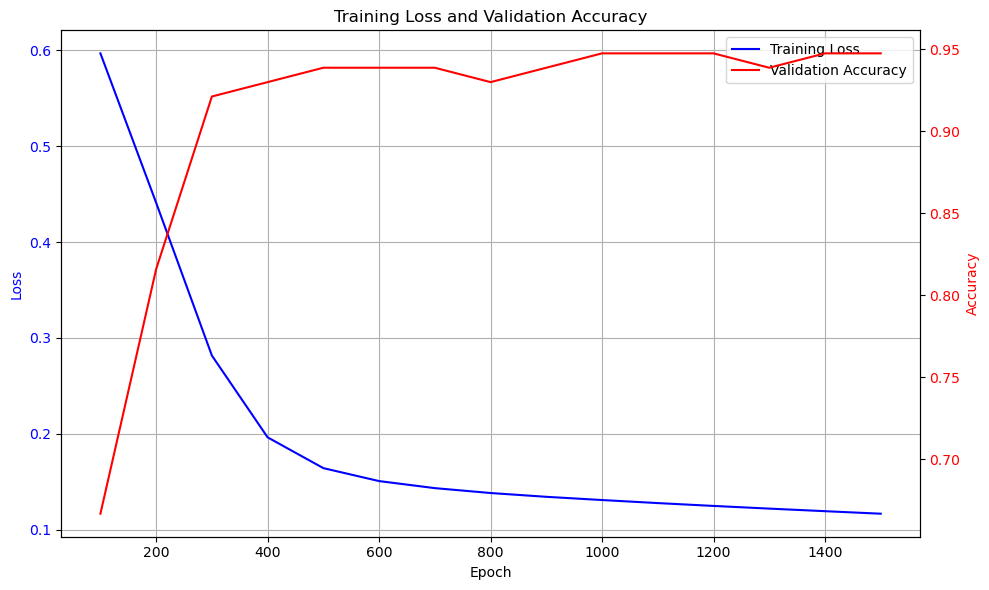

In [165]:
# TODO
import matplotlib.pyplot as plt

# Lists to store training loss and validation accuracy
train_losses = []
val_accuracies = []
epochs_loss = []
epochs_acc = []

nepoch = 1500
log_interval = 100
val_interval = 100

for epoch_id in range(1, nepoch + 1):
    # Training phase
    net.train()
    epoch_losses = []
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    # Calculate average training loss for this epoch
    avg_loss = np.mean(epoch_losses)
    
    # Log and store training loss every 100 epochs
    if epoch_id % log_interval == 0:
        print("Epoch %4d  Avg train loss: %.4f" % (epoch_id, avg_loss))
        train_losses.append(avg_loss)
        epochs_loss.append(epoch_id)
    
    # Compute validation accuracy every 200 epochs
    if epoch_id % val_interval == 0:
        net.eval()
        test_nobs = 0
        ncorrect = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = net(inputs)
                pred = (outputs.squeeze() > 0.5).float()
                tmp_correct = (pred == targets).sum().item()
                
                ncorrect += tmp_correct
                test_nobs += len(pred)
        
        accuracy = ncorrect / test_nobs
        print(" -> Validation accuracy at epoch %d: %.4f" % (epoch_id, accuracy))
        val_accuracies.append(accuracy)
        epochs_acc.append(epoch_id)

# Plot training loss and validation accuracy
plt.figure(figsize=(10, 6))

ax1 = plt.gca()

# Training Loss (Left Y-axis)
line1 = ax1.plot(epochs_loss, train_losses, 'b-', label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Create second Y-axis for validation accuracy
ax2 = ax1.twinx()
line2 = ax2.plot(epochs_acc, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

plt.title('Training Loss and Validation Accuracy')
plt.tight_layout()
plt.show()

### Sanity Check

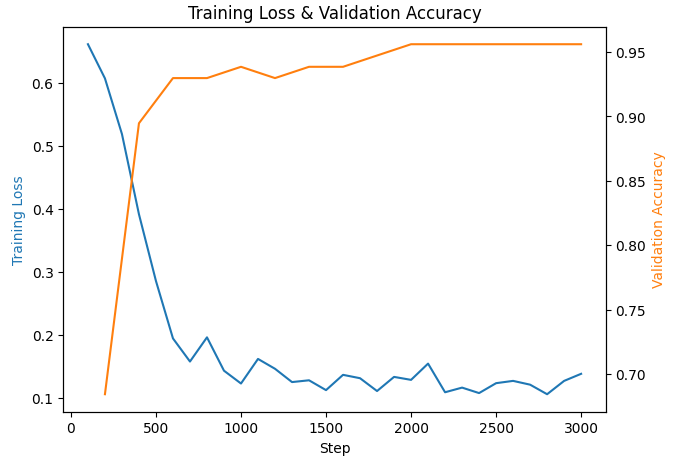

# Exercise (No Need to Turn In)

* Add more hidden layers. How does the performance change?
* Adjust hidden layer wideth. How does the performance change?
* Do more training epochs increase performance?
* Use `torch.nn.CrossEntropyLoss()` instead of `torch.nn.BCELoss()` and adjustment the code accordingly. 

# Online Resource

* Pytorch 60 minutes blitz: <https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html>
* Learning Pytorch with Examples: <https://pytorch.org/tutorials/beginner/pytorch_with_examples.html>
* What is torch.nn really?: <https://pytorch.org/tutorials/beginner/nn_tutorial.html>
* Visualizing models, data, and training with Tensorboard <https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html>
* Live Loss Plot: <https://github.com/stared/livelossplot>
* Also a good reference: <https://github.com/yunjey/pytorch-tutorial>